# Overview
The goal is to make a simple Keras model for predicting which category an image falls in

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [3]:
image_bbox_df = pd.read_csv('../input/lung-opacity-overview/image_bbox_full.csv')
image_bbox_df['path'] = image_bbox_df['path'].map(lambda x: 
                                                  x.replace('input', 
                                                            'input/rsna-pneumonia-detection-challenge'))
print(image_bbox_df.shape[0], 'images')
image_bbox_df.sample(3)

30227 images


,patientId,x,y,width,height,Target,class,boxes,path
137,020380f8-5c5a-4ded-bdf3-9ce3036945b4,642.0,460.0,167.0,258.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
2216,18a81d53-15a3-470e-b51a-98d9348189e4,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...
1132,0bad22f7-1833-43bc-92ec-ac2aba6e1ef7,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...


In [4]:
# get the labels in the right format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
image_bbox_df['class_idx'] = class_enc.fit_transform(image_bbox_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_bbox_df['class_vec'] = oh_enc.fit_transform(
    image_bbox_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_bbox_df.sample(3)

,patientId,x,y,width,height,Target,class,boxes,path,class_idx,class_vec
10867,69988cdb-ff26-4cac-8c7a-6a814d8b58dd,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...,2,"[0.0, 0.0, 1.0]"
10430,661ca6dc-2132-4e8b-bac6-67add068a186,737.0,492.0,115.0,106.0,1,Lung Opacity,1,../input/rsna-pneumonia-detection-challenge/st...,0,"[1.0, 0.0, 0.0]"
23196,c7024796-39ed-4eda-906d-65a1fb5d5c52,651.0,404.0,241.0,255.0,1,Lung Opacity,1,../input/rsna-pneumonia-detection-challenge/st...,0,"[1.0, 0.0, 0.0]"


# Split into Training and Validation
This will give us some feedback on how well our model is doing and if we are overfitting

In [5]:
from sklearn.model_selection import train_test_split
image_df = image_bbox_df.groupby('patientId').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(20013, 11) training data
(6671, 11) validation data


## Balance Training Set
And reduce the total image count

7998 new training size


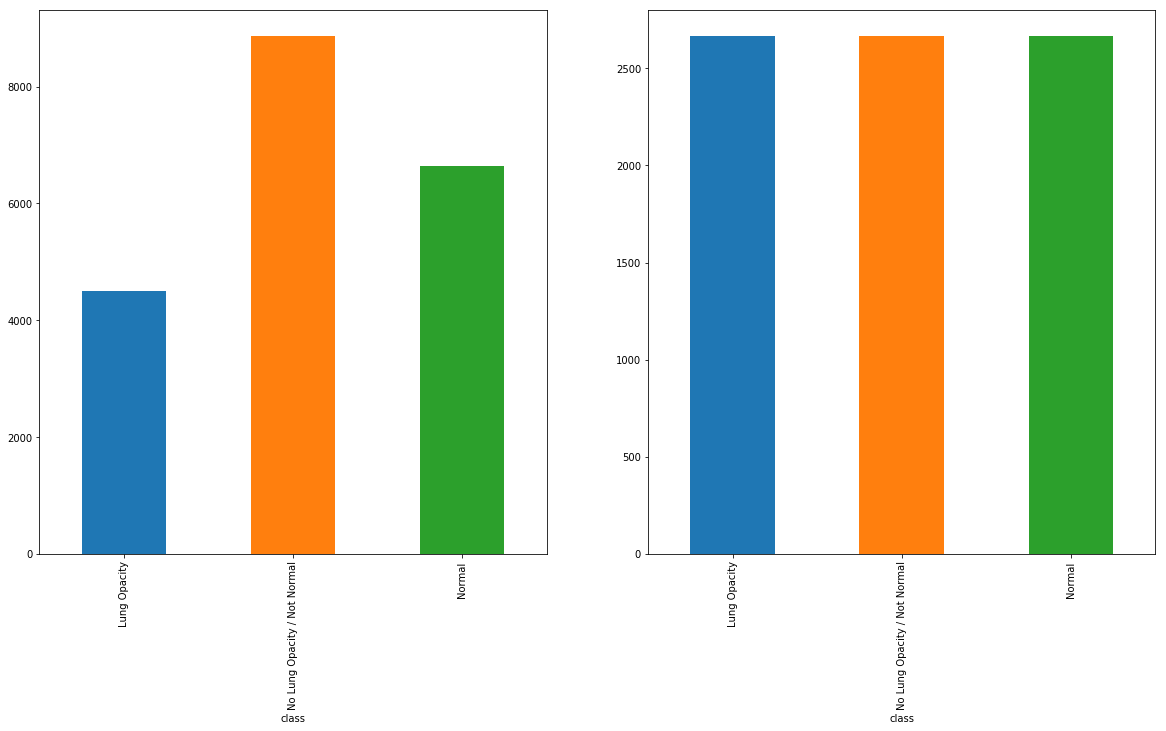

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
raw_train_df.groupby('class').size().plot.bar(ax=ax1)
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

## Keras Image Transplantation
Since Keras is design for color jpeg images we need to hack a bit to make it dicom friendly

In [7]:
try:
    # keras 2.2
    import keras_preprocessing.image as KPImage
except:
    # keras 2.1
    import keras.preprocessing.image as KPImage
    
from PIL import Image
import pydicom
def read_dicom_image(in_path):
    img_arr = pydicom.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

# Data Augmentation
Here we can perform simple augmentation (the `imgaug` and `Augmentation` packages offer much more flexiblity). In order to setup the augmentation we need to know which model we are using

In [8]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.


In [9]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [10]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [11]:
train_gen = flow_from_dataframe(img_gen, train_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

valid_gen = flow_from_dataframe(img_gen, valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
valid_X, valid_Y = next(flow_from_dataframe(img_gen, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = TEST_SAMPLES)) # one big batch

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7998 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images


In [12]:
train_df[train_df['class'] == 'No Lung Opacity / Not Normal']

,patientId,x,y,width,height,Target,class,boxes,path,class_idx,class_vec
2666,e88bffa5-8953-4994-942f-4fa483baf2c7,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2667,57f9ff69-4ee1-4205-b8a0-47b40a46ea08,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2668,8a225736-714d-489a-9cb5-ef44f4c09774,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2669,710fbf77-85ac-4974-9077-0d4d9fdb3e48,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2670,cce563f4-a960-409f-9b1d-a7105c419b87,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2671,ebd485b0-e788-44e2-8f85-a98a6cb2d153,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2672,51fc4515-e145-4e05-ad32-feb6cfd2ec0b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2673,a030aab1-4f95-4169-9e9f-e2f2a3dd9a82,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2674,7bc6f7d5-aa35-4c1e-86d8-c4df27c483b8,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
2675,24ef2877-64ae-4c8a-acb5-6e1c302dc7d2,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"


In [13]:
train_gen.classes

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Show a batch
Here we see what the augmentation actually looks like on a few sample images

(24, 224, 224, 3) (24, 3)


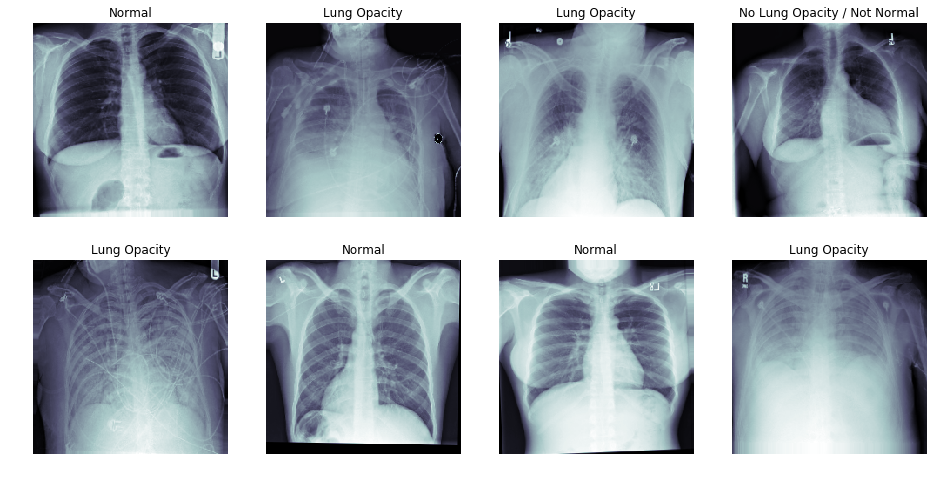

In [14]:
t_x, t_y = next(train_gen)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % class_enc.classes_[np.argmax(c_y)])
    c_ax.axis('off')

# Build our pretrained model
Here we build the pretrained model and download the weights

In [15]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


## Model Supplements
Here we add a few other layers to the model to make it better suited for the classification problem. 

In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(t_y.shape[1], activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
pneu_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
train_gen.batch_size = BATCH_SIZE
pneu_model.fit_generator(train_gen, 
                         steps_per_epoch=train_gen.n//BATCH_SIZE,
                         validation_data=(valid_X, valid_Y), 
                         epochs=20, 
                         callbacks=callbacks_list,
                         workers=2)

In [ ]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

In [ ]:
pred_Y = pneu_model.predict(valid_X, 
                          batch_size = BATCH_SIZE, 
                          verbose = True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y[:,0]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')
fig.savefig('roc_valid.pdf')

### Simple Strategy
We use the `Lung Opacity` as our confidence and predict the image image. It will hopefully do a little bit better than a trivial baseline, and can be massively improved.

In [ ]:
pred_avg_df['PredictionString'] = pred_avg_df['Lung Opacity'].map(lambda x: ('%2.2f 0 0 1024 1024' % x) if x>0.5 else '')

In [ ]:
pred_avg_df[['patientId', 'PredictionString']].to_csv('submission.csv', index=False)

# Building Residual attention net

In [16]:
import numpy as np
import pandas as pd
import os
import cv2
from random import shuffle
import scipy
from tqdm import tqdm  
import skimage
from skimage.transform import resize

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda

from keras.layers import Input
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [17]:
def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1, blockName=None):

    if output_channels is None:
        output_channels = input.get_shape()[-1].value
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

#     x = BatchNormalization()(input)
#     x = Activation('relu')(x)
#     x = Conv2D(input_channels, (1, 1))(x)
 
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    if blockName is not None:
        blockName = blockName + 'conv1'
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride, name=blockName )(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if blockName is not None:
        blockName = blockName + 'conv2'
    x = Conv2D(output_channels, (1, 1), padding='same', name=blockName )(x)

    if input_channels != output_channels or stride != 1:
        if blockName is not None:
            blockName = blockName + 'conv3'
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides, name=blockName )(input)

    x = Add()([x, input])
    return x

In [18]:
def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):

    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1].value
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Activation('sigmoid')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

In [19]:
def AttentionResNet56(shape=(224, 224, 3), n_channels=64, n_classes=100,
                      dropout=0, regularization=0.01):

    regularizer = l2(regularization)

    input_ = Input(shape=shape)
    #x = Conv2D(n_channels, (7, 7), strides=(2, 2), padding='same')(input_) # 112x112
    x = Conv2D(n_channels, (3, 3), strides=(1, 1), padding='same')(input_) # 224x224
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)  # 56x56 ##same output 224

    x = residual_block(x, output_channels=n_channels * 4,stride=2, blockName = 'resblock1')  # 56x56  ##112
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7                                           ##112

    x = residual_block(x, output_channels=n_channels * 8, stride=2, blockName = 'resblock2')  # 28x28  ##56
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7                                           ##56
    
    x = residual_block(x, output_channels=n_channels * 8, stride=2, blockName = 'resblock3')  # 28x28   ##28
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7  ##28
    
    x = residual_block(x, output_channels=n_channels * 8, stride=2, blockName = 'resblock4')  # 28x28   ##14
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7  ##14

    x = residual_block(x, output_channels=n_channels * 16, stride=2, blockName = 'resblock5')  # 7x7
    input_channels_same = x.get_shape()[-1].value
    
    x = residual_block(x, input_channels = input_channels_same,  output_channels=input_channels_same, stride=1, blockName = 'resblock6')  # 7x7
    x = residual_block(x,input_channels = input_channels_same,  output_channels=input_channels_same, stride=1, blockName = 'resblock7')  # 7x7

    pool_size = (x.get_shape()[1].value, x.get_shape()[2].value)
    x = AveragePooling2D(pool_size=pool_size, strides=(1, 1))(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    x = Dense(256, kernel_regularizer=regularizer, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(16, kernel_regularizer=regularizer, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(n_classes, kernel_regularizer=regularizer, activation='softmax')(x)

    model = Model(input_, output)
    return model

In [20]:
model = AttentionResNet56(n_classes=3,dropout=.25)

In [21]:
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [22]:
opt = RMSprop(lr=0.0001, decay=1e-5)
es = EarlyStopping(monitor='val_loss', patience=10, 
                    verbose = 1, 
                    restore_best_weights=True)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [23]:
img_height = 224
img_width = 224

nb_train_samples = 5217
nb_validation_samples = 17
nb_test_samples=624
epochs = 30
batch_size = 16

In [24]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 16 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [25]:
train_gen.classes

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [26]:
len(valid_gen.classes)

6671

In [1]:
#train_gen.batch_size = BATCH_SIZE
#model.fit_generator(train_gen, 
#                         steps_per_epoch=train_gen.n//BATCH_SIZE,
#                         validation_data=(valid_X, valid_Y), 
#                         epochs=60, 
#                         callbacks=[es, chkpt],
#                         workers=2)

30 epochs. 

In [ ]:
#history=model.fit_generator(train_gen,
#                            epochs=epochs,
#                            validation_data=valid_gen,
#                            steps_per_epoch=TRAIN_SAMPLES//8,
#                            callbacks=[es, chkpt],
#                            validation_steps=TEST_SAMPLES // BATCH_SIZE)
#, class_weight=class_weight_dict

Loading the previously trained model

In [28]:
from keras.models import load_model
model = load_model('../input/residual-attention-on-rsna-data/resAtt_mod_rsna (2).h5')

In [71]:
#scores1 = model.evaluate_generator(test_generator, workers = 1, steps=np.ceil(nb_test_samples/batch_size))
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores1[1]*100))

In [ ]:
model.save('resAtt_mod_rsna.h5')

In [33]:
pred_Y_res = model.predict(valid_X, 
                          batch_size = BATCH_SIZE, 
                          verbose = True)

800/800 [==============================] - 14s 18ms/step


                              precision    recall  f1-score   support

                Lung Opacity       0.81      0.18      0.29       163
No Lung Opacity / Not Normal       0.61      0.83      0.70       369
                      Normal       0.77      0.75      0.76       268

                 avg / total       0.70      0.67      0.64       800



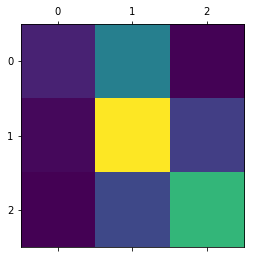

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y_res,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y_res,-1), target_names = class_enc.classes_))

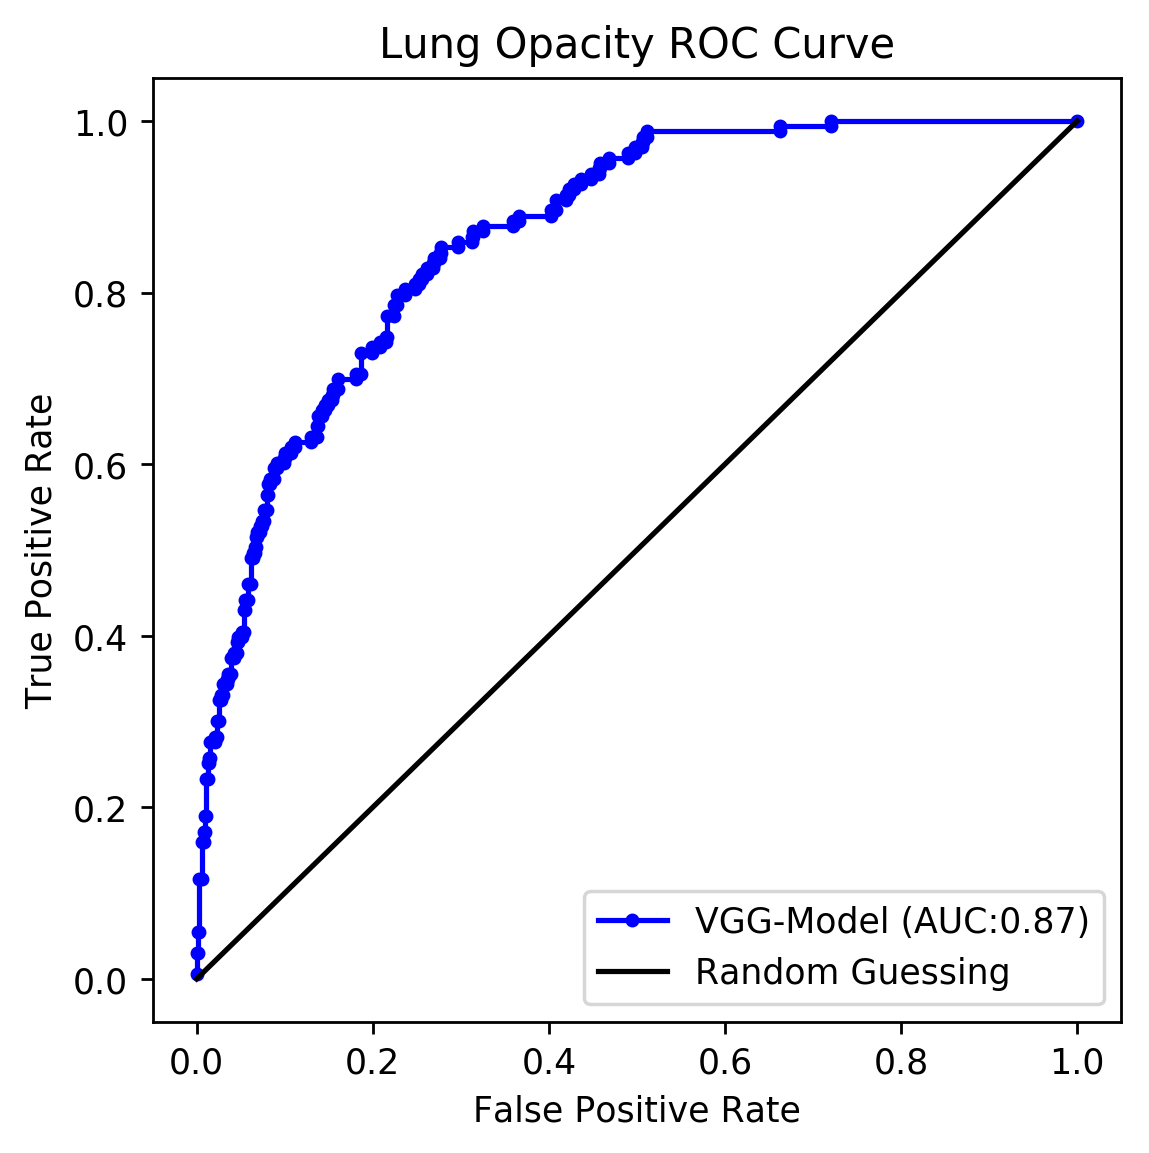

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y_res[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y_res[:,0]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')
fig.savefig('roc_valid.pdf')

Test on our data

In [36]:
TEST_DIR2 =  "../input/"

In [37]:
batch_size_test = 1
nb_test_samples2 = 139

In [38]:
#test_datagen2 = ImageDataGenerator(rescale=1. / 255)

In [39]:
test_generator2 = img_gen.flow_from_directory(
    TEST_DIR2,
    classes=['pneumonia-test'],
    # don't generate labels
    class_mode='sparse',
    # don't shuffle
    shuffle=False,
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    batch_size=batch_size_test,)

Found 139 images belonging to 1 classes.


In [40]:
test_generator2.reset()
preds2 = model.predict_generator(test_generator2, workers = 1,steps=np.ceil(nb_test_samples2/batch_size_test)) #changed worker to 0


In [41]:
preds2

array([[0.5316109 , 0.36501798, 0.10337114],
       [0.2861494 , 0.63026357, 0.08358706],
       [0.28907934, 0.70044816, 0.01047245],
       [0.19957002, 0.5692424 , 0.23118755],
       [0.26272017, 0.5269036 , 0.21037623],
       [0.21095157, 0.4872758 , 0.30177268],
       [0.31078932, 0.5032594 , 0.18595129],
       [0.183978  , 0.7678952 , 0.04812673],
       [0.2979019 , 0.59573257, 0.10636552],
       [0.08211917, 0.23504071, 0.6828401 ],
       [0.1289144 , 0.31819287, 0.55289274],
       [0.19775419, 0.3452827 , 0.45696306],
       [0.44872865, 0.34506077, 0.20621058],
       [0.2838612 , 0.61496395, 0.1011749 ],
       [0.18701118, 0.54857236, 0.26441646],
       [0.09150481, 0.28555262, 0.62294257],
       [0.33796692, 0.56627905, 0.09575403],
       [0.11170448, 0.2370358 , 0.6512597 ],
       [0.2158443 , 0.6543422 , 0.12981354],
       [0.52903736, 0.31466743, 0.15629521],
       [0.24837515, 0.35589027, 0.3957346 ],
       [0.3110547 , 0.46001878, 0.22892652],
       [0.

In [42]:
preds2 = np.argmax(preds2, axis=-1)

In [43]:
preds2

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1,
       1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 1])

 # lung opacity = 1, no lung opacity/not normal  = 0,  normal = 2

In [44]:
pred3 = np.array([0 if xi == 2 else xi for xi in preds2 ])

In [45]:
data = {'col_1': test_generator2.filenames, 'col_2': pred3}
df=pd.DataFrame.from_dict(data)

In [46]:
df


,col_1,col_2
0,pneumonia-test/1.jpg,0
1,pneumonia-test/10.jpg,1
2,pneumonia-test/100.jpg,1
3,pneumonia-test/101.jpg,1
4,pneumonia-test/102.jpg,1
5,pneumonia-test/103.jpg,1
6,pneumonia-test/104.jpg,1
7,pneumonia-test/105.jpg,1
8,pneumonia-test/106.jpg,1
9,pneumonia-test/107.jpg,0


In [47]:
df.to_csv('out_test_res_attntn_trained_on_rsna.csv')

In [48]:
orig_test_labels = test_generator2.classes[test_generator2.index_array]  ##changed

print(orig_test_labels.shape)
print(pred3.shape)

(139,)
(139,)


/opt/conda/lib/python3.6/site-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


<Figure size 432x288 with 0 Axes>

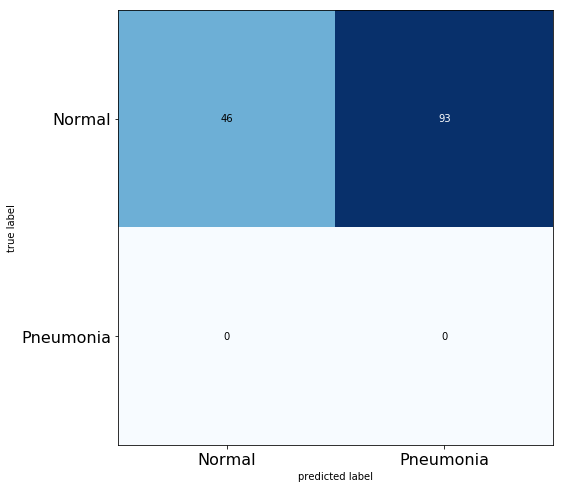

In [49]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, pred3)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show();

In [50]:
df[df['col_2'] == 1]


,col_1,col_2
1,pneumonia-test/10.jpg,1
2,pneumonia-test/100.jpg,1
3,pneumonia-test/101.jpg,1
4,pneumonia-test/102.jpg,1
5,pneumonia-test/103.jpg,1
6,pneumonia-test/104.jpg,1
7,pneumonia-test/105.jpg,1
8,pneumonia-test/106.jpg,1
13,pneumonia-test/110.jpg,1
14,pneumonia-test/111.jpg,1


In [51]:
df[df['col_2'] == 0]


,col_1,col_2
0,pneumonia-test/1.jpg,0
9,pneumonia-test/107.jpg,0
10,pneumonia-test/108.jpg,0
11,pneumonia-test/109.jpg,0
12,pneumonia-test/11.jpg,0
15,pneumonia-test/112.jpg,0
17,pneumonia-test/114.jpg,0
19,pneumonia-test/116.jpg,0
20,pneumonia-test/117.jpg,0
24,pneumonia-test/120.jpg,0


vggnet model

In [52]:
from keras.models import load_model
model_opacity = load_model('../input/lung-opacity-rsna/full_model.h5')

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/saving.py:328: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


loading images again for different image  size for the model

In [53]:
IMG_SIZE

(224, 224)

In [54]:
test_generator_vggnet = img_gen.flow_from_directory(
    TEST_DIR2,
    classes=['pneumonia-test'],
    # don't generate labels
    class_mode='sparse',
    # don't shuffle
    shuffle=False,
    target_size = (384, 384),#((224, 224)
    color_mode = 'rgb',
    batch_size=batch_size_test,)

Found 139 images belonging to 1 classes.


In [55]:
test_generator_vggnet.reset()
preds_vggnet = model_opacity.predict_generator(test_generator_vggnet, workers = 1,steps=np.ceil(nb_test_samples2/batch_size_test)) #changed worker to 0


In [56]:
preds_vggnet

array([[4.48578089e-01, 5.31519830e-01, 1.99021250e-02],
       [2.86447704e-01, 2.06554368e-01, 5.06997943e-01],
       [2.64024228e-01, 6.23283684e-01, 1.12692006e-01],
       [5.56370206e-02, 2.24866182e-01, 7.19496846e-01],
       [5.98053448e-03, 8.31850171e-02, 9.10834491e-01],
       [4.83968966e-02, 4.21720028e-01, 5.29883087e-01],
       [2.42464736e-01, 5.20294785e-01, 2.37240508e-01],
       [1.39513239e-01, 5.88720918e-01, 2.71765888e-01],
       [6.62508070e-01, 2.07469657e-01, 1.30022287e-01],
       [1.35444269e-01, 3.35835963e-01, 5.28719783e-01],
       [5.72504289e-03, 3.14919837e-02, 9.62782979e-01],
       [4.38751847e-01, 4.30571556e-01, 1.30676568e-01],
       [4.69528854e-01, 2.71084070e-01, 2.59387076e-01],
       [6.51296824e-02, 3.64255309e-01, 5.70614994e-01],
       [9.19268280e-02, 5.86527705e-01, 3.21545482e-01],
       [5.32617327e-03, 2.55072545e-02, 9.69166636e-01],
       [4.79418859e-02, 3.70831996e-01, 5.81226110e-01],
       [2.79565025e-02, 9.68477

In [57]:
preds_vggnet = np.argmax(preds_vggnet, axis=-1)

In [58]:
preds_vggnet

array([1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 0, 0, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 0, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2,
       1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 0])

In [59]:
preds_vggnet = np.array([0 if xi == 2 else xi for xi in preds_vggnet ])

In [60]:
data = {'col_1': test_generator_vggnet.filenames, 'col_2': preds_vggnet}
df_vggnet=pd.DataFrame.from_dict(data)

In [61]:
df_vggnet

,col_1,col_2
0,pneumonia-test/1.jpg,1
1,pneumonia-test/10.jpg,0
2,pneumonia-test/100.jpg,1
3,pneumonia-test/101.jpg,0
4,pneumonia-test/102.jpg,0
5,pneumonia-test/103.jpg,0
6,pneumonia-test/104.jpg,1
7,pneumonia-test/105.jpg,1
8,pneumonia-test/106.jpg,0
9,pneumonia-test/107.jpg,0


In [62]:
orig_test_labels = test_generator_vggnet.classes[test_generator_vggnet.index_array]  ##changed

print(orig_test_labels.shape)
print(preds_vggnet.shape)

(139,)
(139,)


<Figure size 432x288 with 0 Axes>

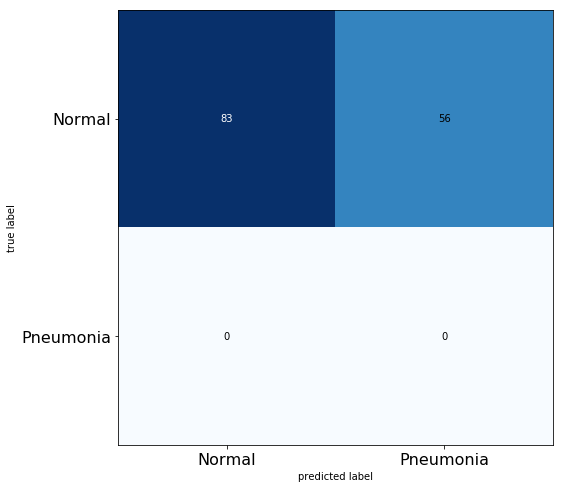

In [63]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds_vggnet)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show();

In [64]:
df_vggnet[df_vggnet['col_2'] == 1]

,col_1,col_2
0,pneumonia-test/1.jpg,1
2,pneumonia-test/100.jpg,1
6,pneumonia-test/104.jpg,1
7,pneumonia-test/105.jpg,1
14,pneumonia-test/111.jpg,1
18,pneumonia-test/115.jpg,1
21,pneumonia-test/118.jpg,1
22,pneumonia-test/119.jpg,1
32,pneumonia-test/128.jpg,1
33,pneumonia-test/129.jpg,1


In [65]:
df_vggnet[df_vggnet['col_2'] == 0]

,col_1,col_2
1,pneumonia-test/10.jpg,0
3,pneumonia-test/101.jpg,0
4,pneumonia-test/102.jpg,0
5,pneumonia-test/103.jpg,0
8,pneumonia-test/106.jpg,0
9,pneumonia-test/107.jpg,0
10,pneumonia-test/108.jpg,0
11,pneumonia-test/109.jpg,0
12,pneumonia-test/11.jpg,0
13,pneumonia-test/110.jpg,0


In [66]:
df_vggnet.to_csv('out_vggnet.csv')

Applying on chest x ray data

In [67]:
os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray")

['.DS_Store', 'train', 'val', 'test']

In [68]:
TEST_DIR =  "../input/chest-xray-pneumonia/chest_xray/chest_xray/test/"

In [69]:
test_generator_chest_vggnet = img_gen.flow_from_directory(
    TEST_DIR,
    # don't generate labels
    class_mode='sparse',
    # don't shuffle
    shuffle=False,
    target_size = (384, 384),#((224, 224)
    color_mode = 'rgb',
    batch_size=1,)

Found 624 images belonging to 2 classes.


Prediction in probability:
[[0.03601649 0.22233173 0.7416518 ]
 [0.00319264 0.02018908 0.9766183 ]
 [0.00403722 0.01614301 0.9798197 ]
 ...
 [0.23104651 0.6602799  0.10867359]
 [0.28784174 0.5359837  0.1761746 ]
 [0.63360083 0.3317112  0.03468801]]
Prediction in class:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1
 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1
 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 

<Figure size 432x288 with 0 Axes>

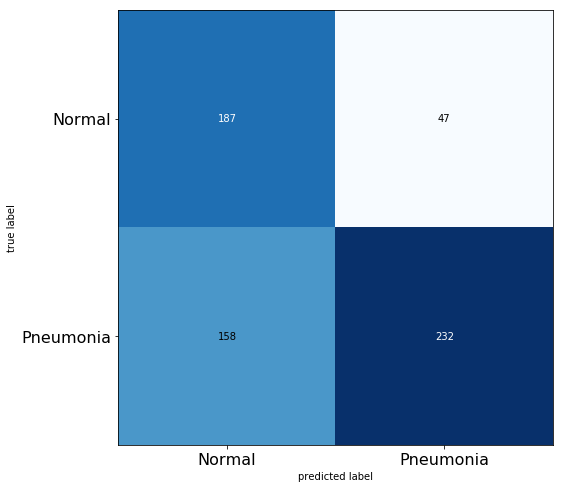

In [70]:
    pred = model_opacity.predict_generator(test_generator_chest_vggnet, workers = 1,steps=np.ceil(624/1))
    print("Prediction in probability:")
    print(pred)
    preds2 = np.argmax(pred, axis=-1)
    preds2 = np.array([0 if xi == 2 else xi for xi in preds2 ])
    print("Prediction in class:")
    print(preds2)
    orig_test_labels = test_generator_chest_vggnet.classes[test_generator_chest_vggnet.index_array]
    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, preds2)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.show();
   